# Playing with the new Biopython KGML rendering module

## Introduction

Biopython 1.65 was [released](http://news.open-bio.org/news/2014/12/biopython-1-65-released/) on 17th December 2014. One of the new additions to the libraries was the `Bio.Graphics.KGML` module, which can be used for customised renderings of KEGG metabolic pathways. 

This notebook is an introduction to the `Bio.KEGG` and `Bio.Graphics.KGML` modules, providing examples of usage, including data retrieval, manipulation and output rendering.

## 0. Setting up

We need to import Biopython and parts of the `KEGG` and `KGML` modules, but first we'll check that a suitably recent version of Biopython is installed (1.65 or higher for Python 2; 1.67 or higher for Python 3):

In [1]:
import Bio
Bio.__version__

'1.66+'

We're going to be using some other Biopython modules, and working with images in the notebook, so we also prepare for this, with the following imports.

In [2]:
from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from Bio.Graphics.ColorSpiral import ColorSpiral

from IPython.display import Image, HTML

import os
import random

To visualise the PDF output generated by this library inline, and to provide a `head`-like peek at text output, the functions below are defined:

In [3]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

# A bit of helper code to shorten long text
def head(text, lines=10):
    """Print the first lines lines of the passed text."""
    print('\n'.join(text.split('\n')[:lines] + ['[...]']))

Output files will be stored in the subdirectory `kgml_output`, which may need to be created:

In [4]:
# Create subdirectory to store output
outdir = "kgml_output"
os.makedirs(outdir, exist_ok=True)

## 1. Retrieving data from KEGG with `Bio.KEGG.REST`

The [KEGG](http://www.genome.jp/kegg/) database provides a RESTful interface to its data (see [http://www.kegg.jp/kegg/rest/](http://www.kegg.jp/kegg/rest/)), which we can use via Biopython's `Bio.KEGG.REST` module.

The KEGG interface is not as well documented as some other resources (such as NCBI or Ensembl), and KEGG does not provide any usage guidelines. To avoid risking overloading the service, Biopython restricts us to three calls per second. Be warned also that the conditions of service include:

>"This service should not be used for bulk data downloads".

**NOTE:** The KEGG API returns data in `Byte` handles (in Python3, these are strings prefixed with the `b` character). Biopython's interface converts text data to `String` handles, but leaves image data as the `Byte` type.

### 1a. Obtaining information about a database with `kegg_info()`

We can obtain basic information about the KEGG databases (e.g. "pathway", "kegg", "hsa", etc.) using the `kegg_info()` function. This returns a handle which can be read as plaintext, with some useful information about the resource.

In [5]:
# Information about the Kyoto Encyclopedia of Genes and Genomes
print(kegg_info("kegg").read())

kegg             Kyoto Encyclopedia of Genes and Genomes
kegg             Release 78.0+/05-25, May 16
                 Kanehisa Laboratories
                 pathway     435,883 entries
                 brite       154,899 entries
                 module      356,696 entries
                 disease       1,521 entries
                 drug         10,350 entries
                 environ         850 entries
                 orthology    19,556 entries
                 genome        4,270 entries
                 genes     19,039,452 entries
                 dgenes      602,101 entries
                 compound     17,643 entries
                 glycan       10,989 entries
                 reaction     10,129 entries
                 rpair        15,321 entries
                 rclass        3,033 entries
                 enzyme        6,728 entries



In [6]:
# Information about the KEGG Pathway Database
print(kegg_info("pathway").read())

pathway          KEGG Pathway Database
path             Release 78.0+/05-25, May 16
                 Kanehisa Laboratories
                 435,883 entries



In [7]:
# Information about the Escherichia coli K-12 MG1655 KEGG Genes Database
print(kegg_info("eco").read())

T00007           Escherichia coli K-12 MG1655 KEGG Genes Database
eco              Release 78.0+/05-21, May 16
                 Kanehisa Laboratories
                 4,497 entries



### 1b. Obtaining a list of entries in a database with `kegg_list()`

The `kegg_list()` function retrieves a handle, which provides a plaintext tab-separated `key:value` list of entry identifiers and definitions in the given database or set of database entries. 

The `kegg_list()` function allows the organism to be specified for a database, with an optional second argument.

In [8]:
# List all pathways in the pathway database
head(kegg_list('pathway').read())

path:map00010	Glycolysis / Gluconeogenesis
path:map00020	Citrate cycle (TCA cycle)
path:map00030	Pentose phosphate pathway
path:map00040	Pentose and glucuronate interconversions
path:map00051	Fructose and mannose metabolism
path:map00052	Galactose metabolism
path:map00053	Ascorbate and aldarate metabolism
path:map00061	Fatty acid biosynthesis
path:map00062	Fatty acid elongation
path:map00071	Fatty acid degradation
[...]


In [9]:
# Only list pathways present in E. coli K-12 MG1655
head(kegg_list('pathway', 'eco').read())

path:eco00010	Glycolysis / Gluconeogenesis - Escherichia coli K-12 MG1655
path:eco00020	Citrate cycle (TCA cycle) - Escherichia coli K-12 MG1655
path:eco00030	Pentose phosphate pathway - Escherichia coli K-12 MG1655
path:eco00040	Pentose and glucuronate interconversions - Escherichia coli K-12 MG1655
path:eco00051	Fructose and mannose metabolism - Escherichia coli K-12 MG1655
path:eco00052	Galactose metabolism - Escherichia coli K-12 MG1655
path:eco00053	Ascorbate and aldarate metabolism - Escherichia coli K-12 MG1655
path:eco00061	Fatty acid biosynthesis - Escherichia coli K-12 MG1655
path:eco00071	Fatty acid degradation - Escherichia coli K-12 MG1655
path:eco00130	Ubiquinone and other terpenoid-quinone biosynthesis - Escherichia coli K-12 MG1655
[...]


If only the organism is specified, then a list of gene entries is returned.

In [10]:
# E. coli K-12 MG1655 genes
head(kegg_list('eco').read())

eco:b0001	thrL; thr operon leader peptide; K08278 thr operon leader peptide
eco:b0002	thrA; Bifunctional aspartokinase/homoserine dehydrogenase 1 (EC:1.1.1.3 2.7.2.4); K12524 bifunctional aspartokinase / homoserine dehydrogenase 1 [EC:2.7.2.4 1.1.1.3]
eco:b0003	thrB; homoserine kinase (EC:2.7.1.39); K00872 homoserine kinase [EC:2.7.1.39]
eco:b0004	thrC; L-threonine synthase (EC:4.2.3.1); K01733 threonine synthase [EC:4.2.3.1]
eco:b0005	yaaX; DUF2502 family putative periplasmic protein
eco:b0006	yaaA; peroxide resistance protein, lowers intracellular iron; K09861 uncharacterized protein
eco:b0007	yaaJ; putative transporter; K03310 alanine or glycine:cation symporter, AGCS family
eco:b0008	talB; transaldolase B (EC:2.2.1.2); K00616 transaldolase [EC:2.2.1.2]
eco:b0009	mog; molybdochelatase incorporating molybdenum into molybdopterin; K03831 molybdopterin adenylyltransferase [EC:2.7.7.75]
eco:b0010	satP; succinate-acetate transporter; K07034 uncharacterized protein
[...]


The KEGG API also allows the `+` operator to be used to combine list identifiers.

In [11]:
# Compound entry C01290 and glycan entry G00092
print(kegg_list('C01290+G00092').read())

cpd:C01290	beta-D-Galactosyl-(1->4)-beta-D-glucosyl-(1<->1)-ceramide; beta-D-Galactosyl-1,4-beta-D-glucosylceramide; Lactosylceramide; Gal-beta1->4Glc-beta1->1'Cer; LacCer; Lactosyl-N-acylsphingosine; D-Galactosyl-1,4-beta-D-glucosylceramide
gl:G00092	Lactosylceramide; CDw17; LacCer; (Gal)1 (Glc)1 (Cer)1; Glycolipid; Sphingolipid



But `kegg_list()` and other functions will take a Python `list` of identifiers, and combine them automatically:

In [12]:
# Compound entry C01290 and glycan entry G00092
print(kegg_list(['C01290', 'G00092']).read())

cpd:C01290	beta-D-Galactosyl-(1->4)-beta-D-glucosyl-(1<->1)-ceramide; beta-D-Galactosyl-1,4-beta-D-glucosylceramide; Lactosylceramide; Gal-beta1->4Glc-beta1->1'Cer; LacCer; Lactosyl-N-acylsphingosine; D-Galactosyl-1,4-beta-D-glucosylceramide
gl:G00092	Lactosylceramide; CDw17; LacCer; (Gal)1 (Glc)1 (Cer)1; Glycolipid; Sphingolipid



### 1c. Finding a specific entry with `kegg_find()`

The `kegg_find(database, query)` function finds entries with matching `query` keywords or other `query` data in a given `database`. Data is returned as tab-separated `key:value` plain text.

In [13]:
# Find shiga toxin genes
head(kegg_find('genes', 'shiga+toxin').read())

ece:Z1464	stx2A; shiga-like toxin II A subunit encoded by bacteriophage BP-933W; K11006 shiga toxin subunit A
ece:Z1465	stx2B; shiga-like toxin II B subunit encoded by bacteriophage BP-933W; K11007 shiga toxin subunit B
ece:Z3343	stx1B; shiga-like toxin 1 subunit B encoded within prophage CP-933V; K11007 shiga toxin subunit B
ece:Z3344	stx1A; shiga-like toxin 1 subunit A encoded within prophage CP-933V; K11006 shiga toxin subunit A
ecs:ECs1205	Shiga toxin 2 subunit A; K11006 shiga toxin subunit A
ecs:ECs1206	Shiga toxin 2 subunit B; K11007 shiga toxin subunit B
ecs:ECs2973	Shiga toxin I subunit B; K11007 shiga toxin subunit B
ecs:ECs2974	Shiga toxin I subunit A; K11006 shiga toxin subunit A
ecf:ECH74115_2905	shigatoxin 2, subunit B; K11007 shiga toxin subunit B
ecf:ECH74115_2906	shiga toxin subunit A; K11006 shiga toxin subunit A
[...]


In [14]:
# Find shiga toxin genes only in Escherichia coli O111 H-11128 (EHEC)
print(kegg_find('eoi', 'shiga+toxin').read())

eoi:ECO111_2429	Shiga toxin 2 subunit B; K11007 shiga toxin subunit B
eoi:ECO111_2430	Shiga toxin 2 subunit A; K11006 shiga toxin subunit A
eoi:ECO111_3361	Shiga toxin 1 subunit A; K11006 shiga toxin subunit A
eoi:ECO111_3362	Shiga toxin 1 subunit B; K11007 shiga toxin subunit B



The API lets us query on useful properties, such as compound molecular weight:

In [15]:
# Compounds with molecular weight between 300 and 310g/mol
head(kegg_find('compound', '300-310/mol_weight').read())

cpd:C00051	307.32348
cpd:C00200	306.33696
cpd:C00219	304.46688
cpd:C00239	307.197122
cpd:C00270	309.26986
cpd:C00357	301.187702
cpd:C00365	308.181882
cpd:C00389	302.2357
cpd:C00732	308.37276
cpd:C00777	300.43512
[...]


### 1d. Retrieving specific entries with `kegg_get()`

The `kegg_get()` function lets us retrieve data from KEGG in a range of different formats. 

Database entries can be retrieved directly as plain text; sequences may be returned as database entries, amino acid or nucleotide sequences in FASTA format; compounds as database entries, or images (`.gif`); pathways as database entries, KGML, or images (`.png`).

Compounds can be retrieved as their database entry in plain text, or as a `.gif` image.

In [16]:
# Compound as database entry
head(kegg_get("cpd:C01290").read())

ENTRY       C01290                      Compound
NAME        beta-D-Galactosyl-(1->4)-beta-D-glucosyl-(1<->1)-ceramide;
            beta-D-Galactosyl-1,4-beta-D-glucosylceramide;
            Lactosylceramide;
            Gal-beta1->4Glc-beta1->1'Cer;
            LacCer;
            Lactosyl-N-acylsphingosine;
            D-Galactosyl-1,4-beta-D-glucosylceramide
FORMULA     C31H56NO13R
REMARK      Same as: G00092
[...]


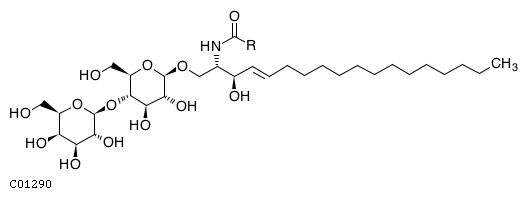

In [17]:
# Compound as image
Image(kegg_get("cpd:C01290", "image").read())

Gene data can be retrieved as the plain text database entry, or a FASTA nucleotide or protein sequence.

In [18]:
# Gene as database entry
head(kegg_get("ece:Z5100").read())

ENTRY       Z5100             CDS       T00044
NAME        espF
DEFINITION  (GenBank) espF
ORTHOLOGY   K12786  LEE-encoded effector EspF
ORGANISM    ece  Escherichia coli O157:H7 EDL933 (EHEC)
PATHWAY     ece05130  Pathogenic Escherichia coli infection
MODULE      ece_M00542  EHEC/EPEC pathogenicity signature, T3SS and effectors
BRITE       KEGG Orthology (KO) [BR:ece00001]
             Human Diseases
              Infectious diseases
[...]


In [19]:
# Gene as amino acid sequence
print(kegg_get("ece:Z5100", "aaseq").read())

>ece:Z5100 espF; espF; K12786 LEE-encoded effector EspF (A)
MLNGISNAASTLGRQLVGIASRVSSAGGTGFSVAPQAVRLTPVKVHSPFSPGSSNVNART
IFNVSSQVTSFTPSRPAPPPPTSGQASGASRPLPPIAQALKEHLAAYEKSKGPEALGFKP
ARQAPPPPTSGQASGASRPLPPIAQALKEHLAAYEKSKGPEALGFKPARQAPPPPTSGQA
SGASRPLPPIAQALKEHLAAYEKSKGPEALGFKPARQAPPPPTGPSGLPPLAQALKDHLA
AYEQSKKG



In [20]:
# Gene as nucleotide sequence
print(kegg_get("ece:Z5100", "ntseq").read())

>ece:Z5100 espF; espF; K12786 LEE-encoded effector EspF (N)
atgcttaatggaattagtaacgctgcttctacactagggcggcagcttgtaggtatcgca
agtcgagtgagctctgcggggggaactggattttctgtagcccctcaggccgtgcgtctt
actccggtgaaagttcattcccctttttctccaggctcgtcgaatgttaatgcgagaacg
atttttaatgtgagcagccaggtgacttcatttactccctctcgtccggcaccgccgcca
ccgacaagtggacaggcatccggggcatcccgacctttaccgcccattgcacaggcatta
aaagagcacttggctgcctatgaaaaatcgaaaggtcctgaggctttaggttttaagccc
gcccgtcaggcaccgccgccaccgacaagtggacaggcatccggggcatcccgaccttta
ccgcccattgcacaggcattaaaagagcacttggctgcctatgaaaaatcgaaaggtcct
gaggctttaggttttaagcccgcccgtcaggcaccgccgccaccgacaagtggacaggca
tccggggcatcccgacctttaccgcccattgcacaggcattaaaagagcacttggctgcc
tatgaaaaatcgaaaggtcctgaggctttaggttttaagcccgcccgtcaggcaccaccg
ccaccgacagggcctagtggactaccgccccttgcacaggcattaaaagatcatttagct
gcctatgagcaatcgaagaaagggtaa



In [21]:
# Parsing a returned sequence with SeqIO, and converting format
seq = SeqIO.read(kegg_get("ece:Z5100", "ntseq"), 'fasta')
print(seq.format('stockholm'))

# STOCKHOLM 1.0
#=GF SQ 1
ece:Z5100 atgcttaatggaattagtaacgctgcttctacactagggcggcagcttgtaggtatcgcaagtcgagtgagctctgcggggggaactggattttctgtagcccctcaggccgtgcgtcttactccggtgaaagttcattcccctttttctccaggctcgtcgaatgttaatgcgagaacgatttttaatgtgagcagccaggtgacttcatttactccctctcgtccggcaccgccgccaccgacaagtggacaggcatccggggcatcccgacctttaccgcccattgcacaggcattaaaagagcacttggctgcctatgaaaaatcgaaaggtcctgaggctttaggttttaagcccgcccgtcaggcaccgccgccaccgacaagtggacaggcatccggggcatcccgacctttaccgcccattgcacaggcattaaaagagcacttggctgcctatgaaaaatcgaaaggtcctgaggctttaggttttaagcccgcccgtcaggcaccgccgccaccgacaagtggacaggcatccggggcatcccgacctttaccgcccattgcacaggcattaaaagagcacttggctgcctatgaaaaatcgaaaggtcctgaggctttaggttttaagcccgcccgtcaggcaccaccgccaccgacagggcctagtggactaccgccccttgcacaggcattaaaagatcatttagctgcctatgagcaatcgaagaaagggtaa
#=GS ece:Z5100 AC ece:Z5100
#=GS ece:Z5100 DE ece:Z5100 espF; espF; K12786 LEE-encoded effector EspF (N)
//



Pathways can be returned as database entries in plain text, or in the KGML format, or as `.png` images. These last two formats are especially useful for generating custom pathway renderings with `Bio.Graphics.KGML`.

In [22]:
# Pathway as database entry
head(kegg_get("hsa05130").read())

ENTRY       hsa05130                    Pathway
NAME        Pathogenic Escherichia coli infection - Homo sapiens (human)
DESCRIPTION Enteropathogenic E. coli (EPEC) and enterohemorrhagic E. coli (EHEC) are closely related pathogenic strains of Escherichia coli. The hallmark of EPEC/EHEC infections [DS:H00278 H00277] is induction of attaching and effacing (A/E) lesions that damage intestinal epithelial cells. The capacity to form A/E lesions is encoded mainly by the locus of enterocyte effacement (LEE) pathogenicity island. Tir, Map, EspF, EspG are known LEE-encoded effector proteins secreted via the type III secretion system, which is also LEE-encoded, into the host cell. EPEC and EHEC Tir's link the extracellular bacterium to the cell cytoskeleton. Map and EspF are involved in mitochondrion membrane permeabilization. EspG interacts with tubulins and stimulates microtubule destabilization. LEE-encoded adhesin or intimin (Eae) is exported via the general secretory pathway to the peripla

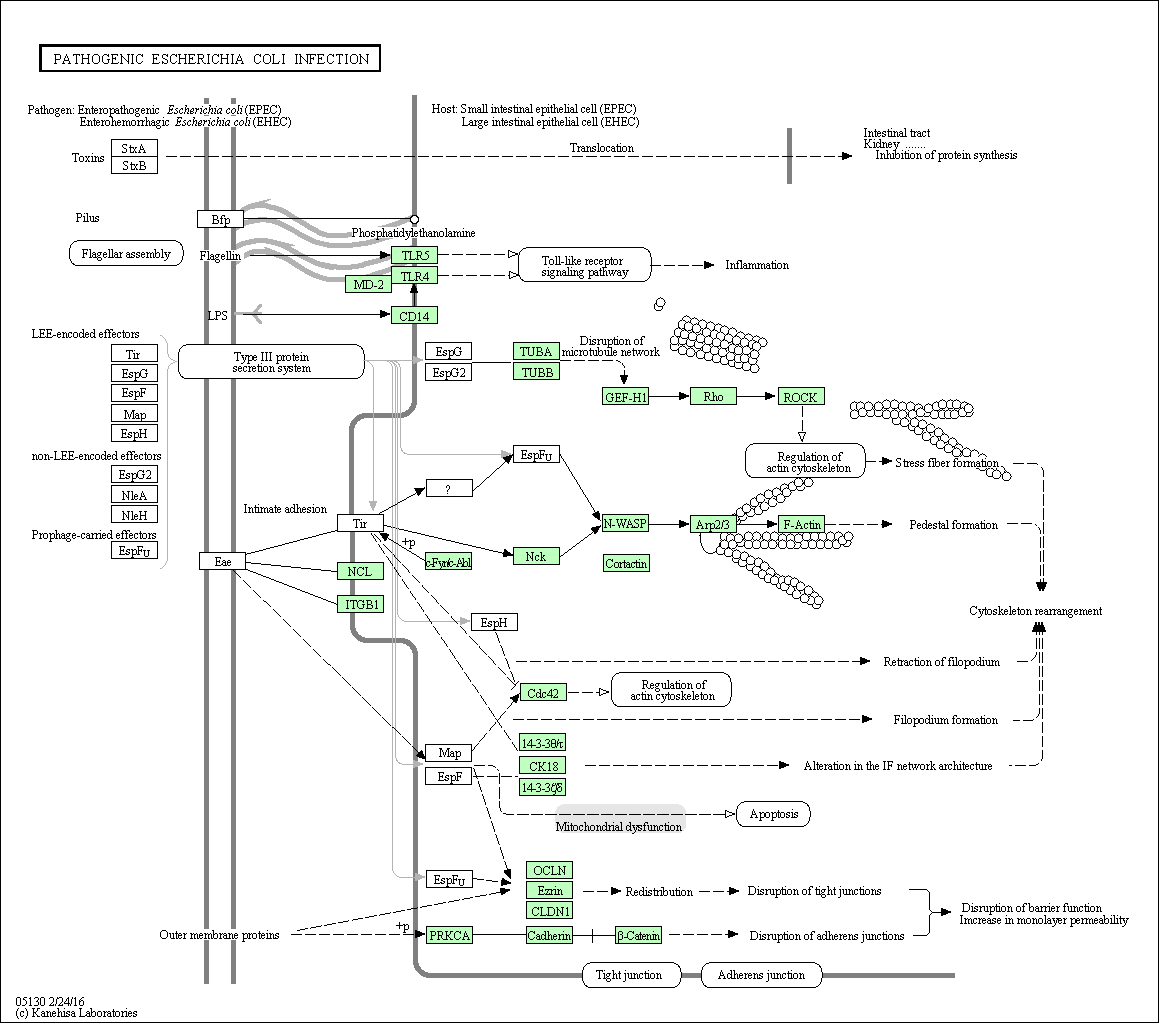

In [23]:
# Pathway as image (png)
Image(kegg_get("hsa05130", "image").read())

In [24]:
# Pathway as KGML
head(kegg_get("hsa05130", "kgml").read())

<?xml version="1.0"?>
<!DOCTYPE pathway SYSTEM "http://www.kegg.jp/kegg/xml/KGML_v0.7.1_.dtd">
<!-- Creation date: Feb 24, 2016 14:42:27 +0900 (GMT+9) -->
<pathway name="path:hsa05130" org="hsa" number="05130"
         title="Pathogenic Escherichia coli infection"
         image="http://www.kegg.jp/kegg/pathway/hsa/hsa05130.png"
         link="http://www.kegg.jp/kegg-bin/show_pathway?hsa05130">
    <entry id="1" name="path:hsa04810" type="map"
        link="http://www.kegg.jp/dbget-bin/www_bget?hsa04810">
        <graphics name="Regulation of actin cytoskeleton" fgcolor="#000000" bgcolor="#FFFFFF"
[...]


## 2. Rendering pathways with `Bio.KEGG` and `Bio.Graphics.KGML`

## 2a. Retrieving renderings from KEGG

The easiest way to render a pathway is to retrieve an image file directly from KEGG with `kegg_get()`, as above.

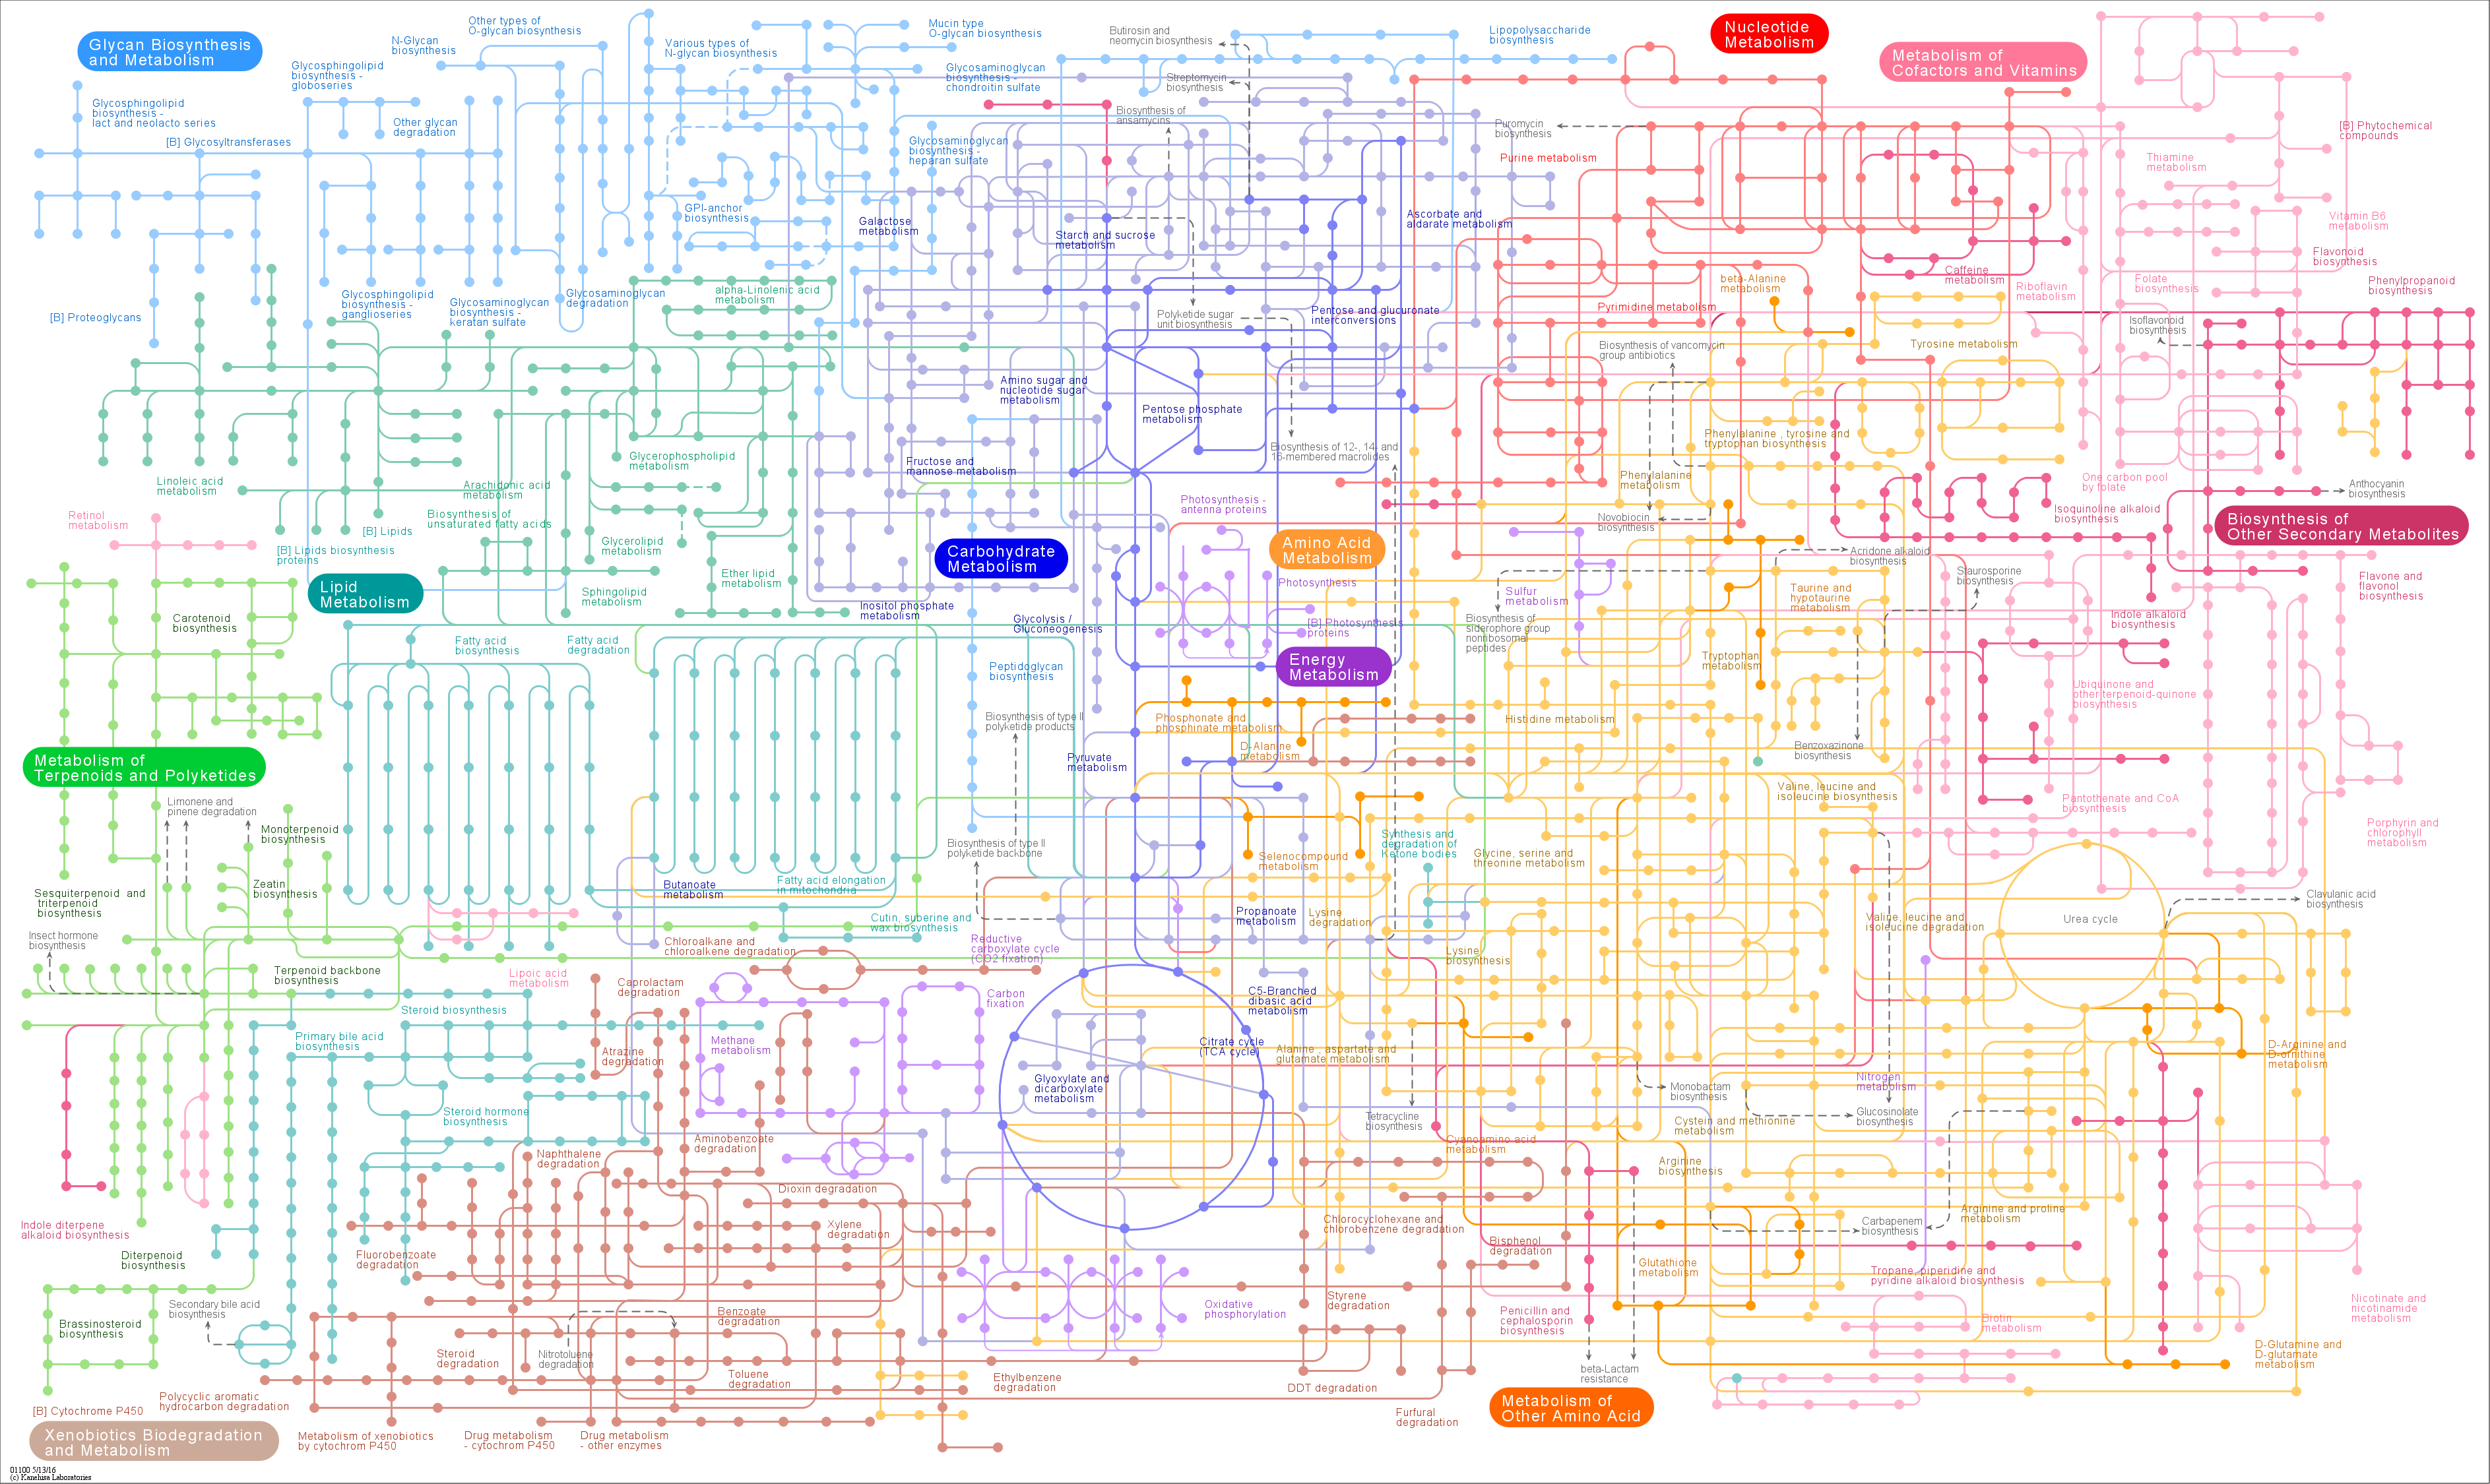

In [25]:
# Render central metabolism
Image(kegg_get("map01100", "image").read())

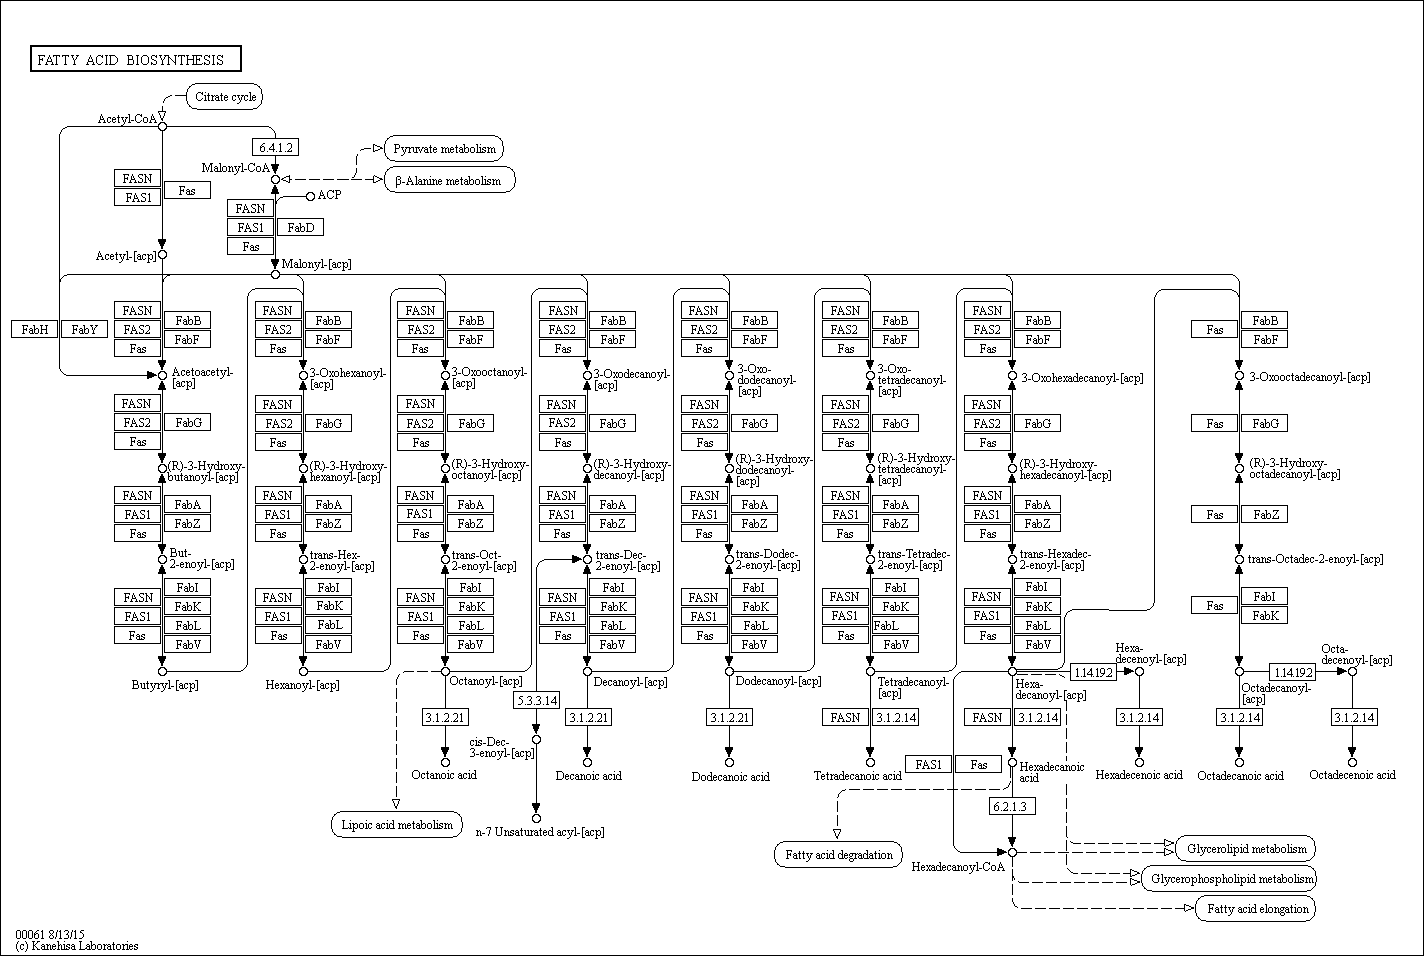

In [26]:
# Render fatty-acid biosynthesis
Image(kegg_get("map00061", "image").read())

KEGG also provides renderings that are specific to an organism, indicating which elements of the pathway are present in their database for that organism.

For central metabolism, compounds and reactions are only coloured if they are present in the specified organism. Otherwise, they are rendered in grey.

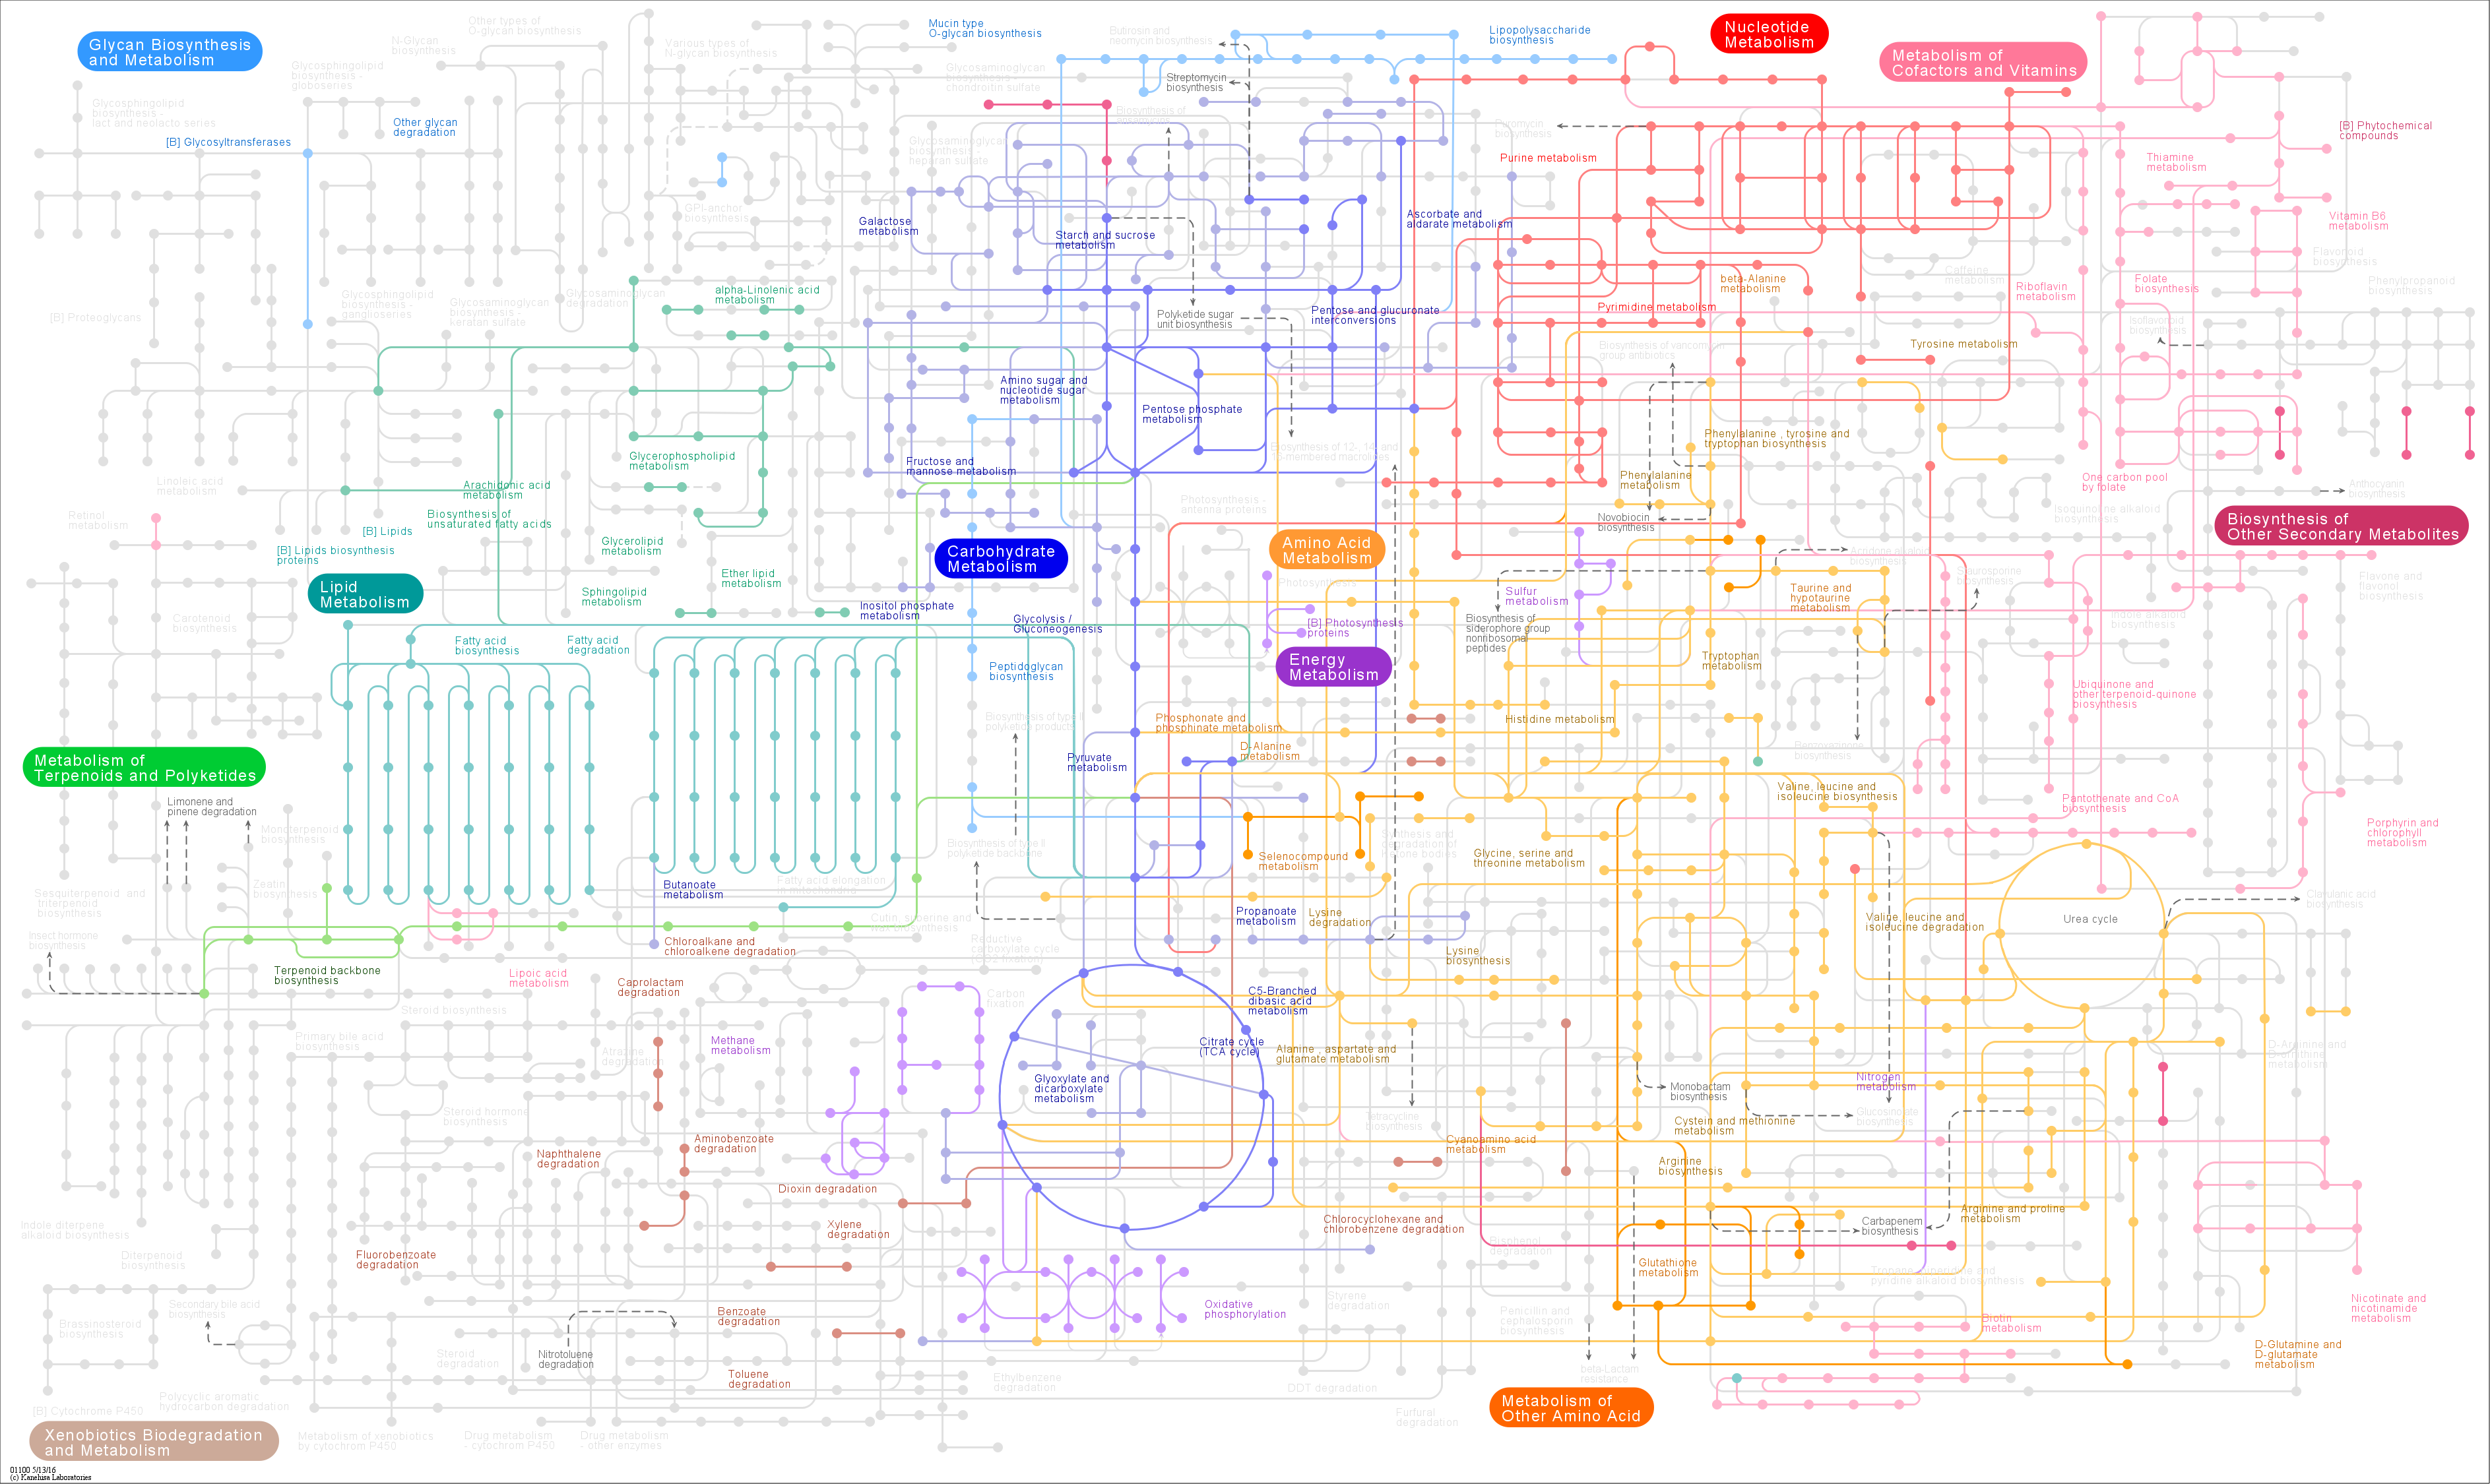

In [27]:
# Render E.coli K-12 MG1655 central metabolism
Image(kegg_get("eco01100", "image").read())

With other pathways, the reactions and/or genes are coloured green when they are present in the organism, and in white otherwise.

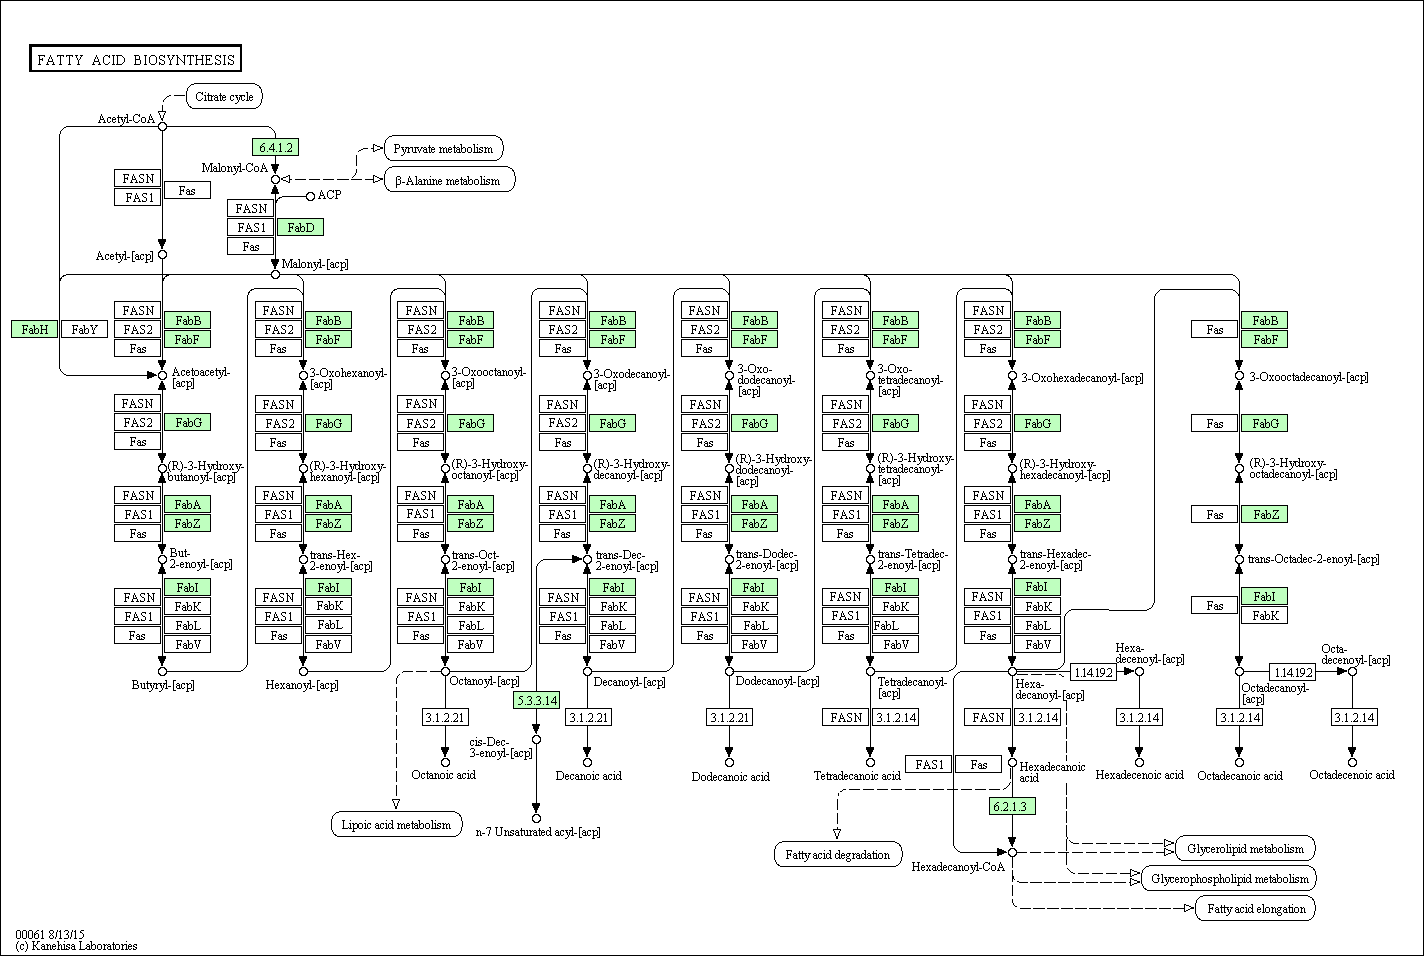

In [28]:
# Render E.coli K-12 MG1655 fatty-acid biosynthesis
Image(kegg_get("eco00061", "image").read())

Three types of reference pathway can also be rendered: `ko`, `ec`, and `rn`. These are shown with blue boxes.

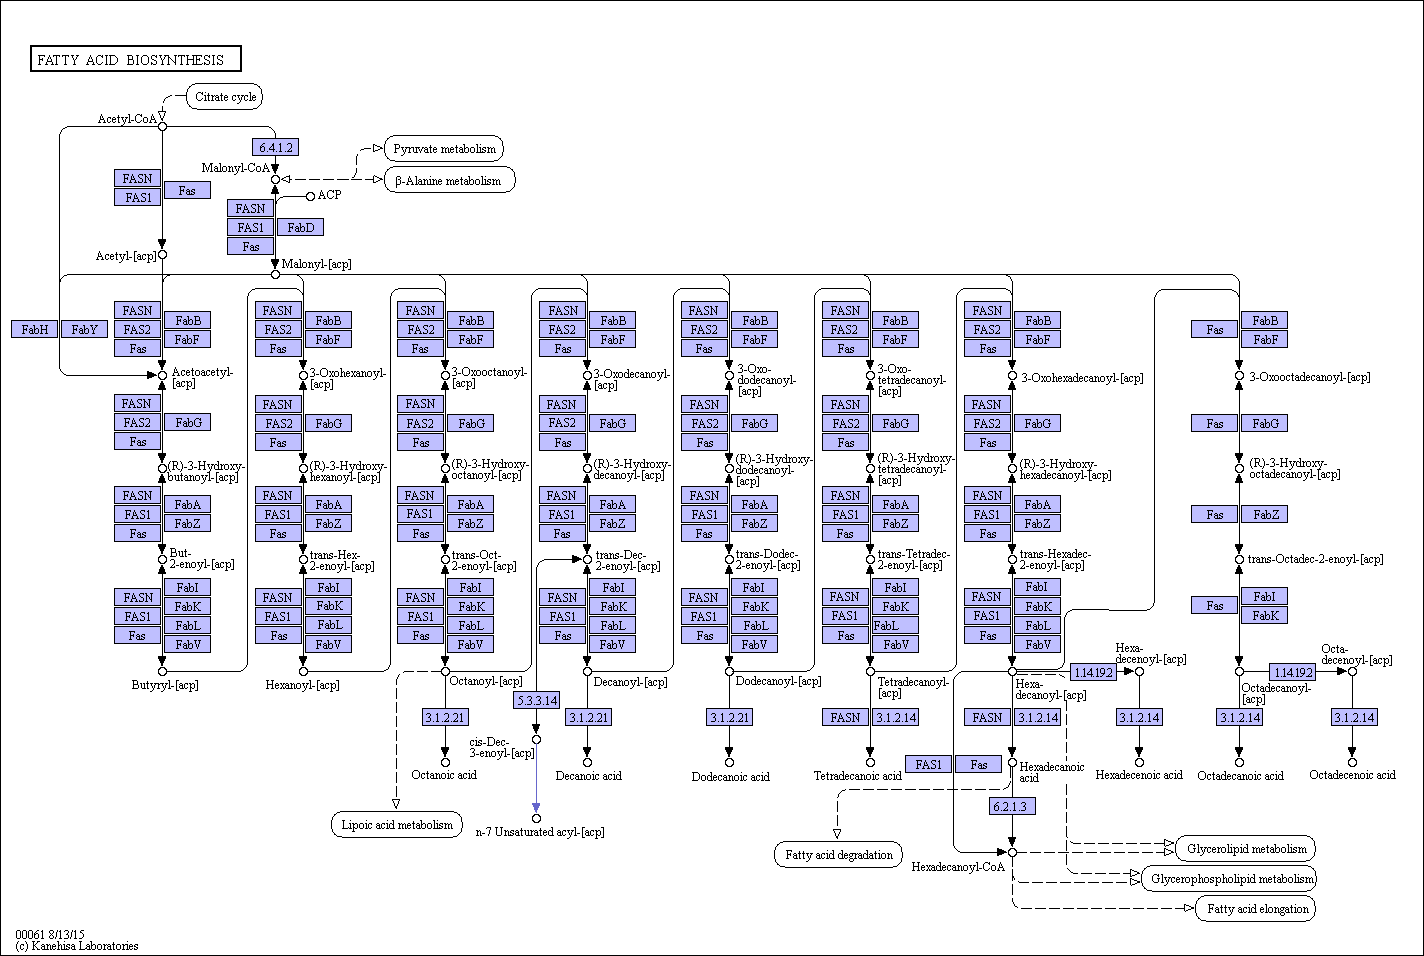

In [29]:
# Render reference fatty-acid biosynthesis
#Image(kegg_get("ko00061", "image").read())
#Image(kegg_get("ec00061", "image").read())
Image(kegg_get("rn00061", "image").read())

## 2b. Reproducing KEGG renderings from KGML

KEGG provides descriptions of their pathway maps in an exchange format called KGML ([spec](http://www.kegg.jp/kegg/xml/)). This doesn't quite match the maps that can be downloaded through the public interface. If you're a subscriber to KEGG, then you have access to an alternative set of [KGML+](http://www.kegg.jp/kegg/download/Readme/README.kgml+) files. The Biopython interface uses the public API, so we only work with KGML files.

To obtain a pathway's KGML file from KEGG, we can use the `kegg_get()` function. In the cell below, we store the downloaded data for two maps in the variables `ko_map` and `eco_map`.

In [30]:
# Get KGML for fatty-acid biosynthesis
ko_map = (kegg_get("ko00061", "kgml").read())    # KO version (KEGG orthologues)
eco_map = (kegg_get("eco00061", "kgml").read())  # E. coli version

Visualising the contents of the KGML file, it can be seen that two useful kinds of elements are described in the file: `ortholog` and `compound` entries. Reactions and other connections are usually not defined directly.

In [31]:
# View the contents of ko_map KGML
head(ko_map, 20)

<?xml version="1.0"?>
<!DOCTYPE pathway SYSTEM "http://www.kegg.jp/kegg/xml/KGML_v0.7.1_.dtd">
<!-- Creation date: Aug 13, 2015 14:15:00 +0900 (GMT+9) -->
<pathway name="path:ko00061" org="ko" number="00061"
         title="Fatty acid biosynthesis"
         image="http://www.kegg.jp/kegg/pathway/ko/ko00061.png"
         link="http://www.kegg.jp/kegg-bin/show_pathway?ko00061">
    <entry id="18" name="ko:K02371" type="ortholog" reaction="rn:R04969"
        link="http://www.kegg.jp/dbget-bin/www_bget?K02371">
        <graphics name="K02371" fgcolor="#000000" bgcolor="#BFBFFF"
             type="rectangle" x="1037" y="606" width="46" height="17"/>
    </entry>
    <entry id="19" name="ko:K02371" type="ortholog" reaction="rn:R04966"
        link="http://www.kegg.jp/dbget-bin/www_bget?K02371">
        <graphics name="K02371" fgcolor="#000000" bgcolor="#BFBFFF"
             type="rectangle" x="895" y="606" width="46" height="17"/>
    </entry>
    <entry id="20" name="ko:K02371" type="orthol

Typically, `ortholog`s and `compound`s are the only items that can be manipulated on a KEGG pathway map. KGML does not describe the complete map, with its connectors and labels, as provided in the downloaded image.

The base maps (such as, in this case, `map00061`) do not contain `ortholog` or `compound` features, and consequently there is no associated KGML file. Attempting to retrieve KGML data for these maps produces an `HTTP 404: not found` error.

In [32]:
# Trying to retrieve base map KGML generates an HTTP 404: not found error
#base_map = (kegg_get("map00061", "kgml").read())

The beautiful images generated by KEGG are rendered as `.png` files, which may be downloaded, and the features described in the accompanying KGML description overlaid, with custom formatting. This is what is currently done in the majority of cases, here.

To do this, first we need to parse the KGML we get from KEGG into a `Pathway` object. This holds an internal representation of the pathway information, such as `ortholog`s and `compound`s (and, as we'll see later, `reaction`s and relations.

The `Pathway` object provides some useful functions for manipulation of elements in the KGML representations, and allows us to write out a new KGML file that preserves the changes we make. Using `print` on the `Pathway` object gives us some summary information.

`KGML_parser` will read a KGML file on disk, and the stream returned from a `kegg_get()` function, as below.

In [33]:
pathway = KGML_parser.read(kegg_get("ko00061", "kgml"))
print(pathway)

Pathway: Fatty acid biosynthesis
KEGG ID: path:ko00061
Image file: http://www.kegg.jp/kegg/pathway/ko/ko00061.png
Organism: ko
Entries: 242
Entry types:
	ortholog: 183
	compound: 50
	map: 9



To render this data as an image, we need to set up a `KGMLCanvas` object, from `Bio.Graphics.KGML_vis`, to draw on. We do this by instantiating a `KGMLCanvas` object with our pathway data.

In [34]:
canvas = KGMLCanvas(pathway)

Now that we have an image, we can render it. At the moment, there is only the capability to render to `.pdf`. To render to a file, call the `draw()` method of the canvas, with the output filename as an argument.

Using the cell below, we also view the `.pdf` file that is created in an `iFrame`.

In [35]:
canvas.draw(os.path.join(outdir, "fab_map.pdf"))
PDF(os.path.join(outdir, "fab_map.pdf"))

But there's something wrong with this picture. It shows only the elements defined in the KGML file. All the beautiful KEGG layout, including the lines indicating the flow of the biochemistry, is missing. That's because the KGML file doesn't contain any information about it, directly. 

However, each `Pathway` object created from KGML file has an `image` attribute with the URL of its `.png` format representation. To use this as a background, all we need to do to render this is specify `import_imagemap=True` when creating the canvas, or set `canvas.import_imagemap = True` once the canvas is created. (It is also possible to specify an image file on disk as the background.)

In [36]:
canvas.import_imagemap = True
canvas.draw(os.path.join(outdir, "fab_map_with_image.pdf"))
PDF(os.path.join(outdir, "fab_map_with_image.pdf"))

This could be encapsulated in a useful helper function, as in the cell below:

In [37]:
def draw_kegg_map(map_id, outdir):
    """Render a local PDF of a KEGG map with the passed map ID."""
    # Get the background image first
    pathway = KGML_parser.read(kegg_get(map_id, "kgml"))
    canvas = KGMLCanvas(pathway, import_imagemap=True)
    img_filename = "%s.pdf" % map_id
    canvas.draw(os.path.join(outdir, img_filename))

### 2c. Customised renderings from KGML - Part 1

In the `Bio.Graphics` model of rendering KGML, we are superimposing the elements described in a KGML file over an associated background image. As a result, only the elements that are described in the KGML file (or that we introduce ourselves...) can be modified. 

The current interface to identifying and retrieving pathway elements is a little obscure as of Biopython 1.65 - if you want to retrieve a particular element by ID or annotation -  but it is possible to modify the graphical elements that are rendered, to produce customised maps from KGML data.

The modifications we can make are:

* shape (`graphics.type`)
* location ($x,y$ co-ordinates: `graphics.x`, `graphics.y`)
* height (`graphics.height`)
* width (`graphics.width`)
* foreground colour (`graphics.fgcolor`)
* background colour (`graphics.bgcolor`)
* label (`graphics.name`)

but this still gives us a lot of flexibility in terms of visual annotation from a dataset. We can also choose to display, or not, elements of interest, and transparency effects are available.

##### A motivating example

As a motivating example, we're going to use the fatty-acid biosynthesis pathway (`map00061`) from earlier, and make the following modifications:

1. colour the `ortholog` elements according to a random choice of colours
2. change the size of each `compound` element to reflect its molecular mass

We saw the default rendering of the `ko00061` pathway earlier:

In [38]:
pathway = KGML_parser.read(kegg_get("ko00061", "kgml"))
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw(os.path.join(outdir, "fab_map_with_image.pdf"))
PDF(os.path.join(outdir, "fab_map_with_image.pdf"))

#### 2c.1 Changing `ortholog` background colours

We can get access to all the pathway `ortholog` elements *via* the `pathway.orthologs` attribute. This will list all `ortholog` elements in the pathway as `Entry` objects.

In [39]:
pathway.orthologs[:5]

In [40]:
print(pathway.orthologs[0])

Entry node ID: 18
Names: ko:K02371
Type: ortholog
Components: set()
Reactions: rn:R04969
Graphics elements: 1 [<Bio.KEGG.KGML.KGML_pathway.Graphics object at 0x10711f780>]



Each `Entry` object has a `graphics` attribute that stores information about how the item is rendered, in a list of `Graphics` objects - this reflects the data structure in the KGML representation, which may have more than one graphical entity per entry in the pathway.

In [41]:
pathway.orthologs[0].graphics

Each `Graphics` object has attributes that may be modified directly:

    name         Label for the graphics object
    x            X-axis position of the object (int)
    y            Y-axis position of the object (int)
    coords       polyline co-ordinates, list of (int, int) tuples
    type         object shape
    width        object width (int)
    height       object height (int)
    fgcolor      object foreground color (hex RGB)
    bgcolor      object background color (hex RGB)
    
There are also two read-only properties that are provided for convenience

    bounds       returns the graphical bounds of the object
    centre       returns the centre of the object as an (x, y) tuple

In [42]:
element = pathway.orthologs[0].graphics[0]
attrs = ["name", "x", "y", "coords", "type", "width", "height",
         "fgcolor", "bgcolor", "bounds", "centre"]
for a in attrs:
    print("element.{0: <10}:\t{1}".format(a, getattr(element, a)))

element.name      :	K02371
element.x         :	1037.0
element.y         :	606.0
element.coords    :	None
element.type      :	rectangle
element.width     :	46.0
element.height    :	17.0
element.fgcolor   :	#000000
element.bgcolor   :	#BFBFFF
element.bounds    :	[(1014.0, 597.5), (1060.0, 614.5)]
element.centre    :	(1037.0, 606.0)


To change the `ortholog` colours, it's possible to loop over the `ortholog` elements in the pathway, and modify their `graphics.bgcolor` attributes.

As KGML expects hex colours in its specification, we also provide hex colours here, using the helper function below:

In [43]:
# Helper function to convert colour as RGB tuple to hex string
def rgb_to_hex(rgb):
    rgb = tuple([int(255*val) for val in rgb])
    return '#' + ''.join([hex(val)[2:] for val in rgb]).upper()

For this example we're defining arbitrary colours, but some obvious uses might include the use of colour to represent some biologically-significant value, like transcript abundance, $\frac{dN}{dS}$, or flux through that step.

In [44]:
# Define arbitrary colours
colorspiral = ColorSpiral()
colorlist = colorspiral.get_colors(len(pathway.orthologs))

# Change the colours of ortholog elements
for color, element in zip(colorlist, pathway.orthologs):
    for graphic in element.graphics:
        graphic.bgcolor = rgb_to_hex(color)

In [45]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw(os.path.join(outdir, "fab_map_new_colours.pdf"))
PDF(os.path.join(outdir, "fab_map_new_colours.pdf"))

#### 2c.2 Changing `compound` sizes

We can get access to the pathway `compound` elements *via* `pathway.compounds`, just as for `ortholog`s, and to change sizes, we can loop over them, modifying both `width` and `height`.

As with the colour changes, the sizes used are arbitrary, but this kind of modification (maybe incorporating colour changes, too) could be used to represent biochemical measurements such as metabolite concentration.

In [46]:
# Change the sizes of compound elements
for size, element in zip(range(8, 8+len(pathway.compounds)), pathway.compounds):
    for graphic in element.graphics:
        graphic.width = size
        graphic.height = size

In [47]:
canvas = KGMLCanvas(pathway, import_imagemap=True)
canvas.draw(os.path.join(outdir, "fab_map_new_sizes.pdf"))
PDF(os.path.join(outdir, "fab_map_new_sizes.pdf"))

### 2d. Customised renderings from KGML - Part 2: central metabolism

The maps we've been considering so far have not been completely described by the publicly-available KGML file. This is true for the great majority of KEGG maps. But there are three KEGG maps: `ko01100`, `ko01110`, and `ko01120` for which this is not the case, and the KGML file provides a lot more information. Specifically, they also describe lines representing reactions that connect metabolite compounds. This gives us quite a lot of scope for modifying their presentation to convey useful information.

In [48]:
# The three KEGG maps with lines representing reactions.
maps = ['ko01100', 'ko01110', 'ko01120']
[draw_kegg_map(map, outdir) for map in maps]
print(kegg_get(maps).read())

ENTRY       ko01100                     Pathway
NAME        Metabolic pathways
PATHWAY_MAP ko01100  Metabolic pathways
DISEASE     H00617  Desmosterolosis
            H00689  Delayed sleep phase syndrome
            H00734  Lamellar ichthyosis (LI) and Non-bullous congenital ichthyosiform erythroderma (NBCIE)
            H00753  Urofacial syndrome
            H00761  SEMD, Pakistani type
            H00804  Multiple cutaneous and uterine leiomyomata
            H00824  Calcification of joints and arteries
            H00920  Exocrine pancreatic insufficiency, dyserythropoietic anemia, and calvarial hyperostosis
            H00946  Arts syndrome
            H01002  Generalized arterial calcification of infancy
///
ENTRY       ko01110                     Pathway
NAME        Biosynthesis of secondary metabolites
PATHWAY_MAP ko01110  Biosynthesis of secondary metabolites
///
ENTRY       ko01120                     Pathway
NAME        Microbial metabolism in diverse environments
PATHWAY_MAP

In [49]:
PDF(os.path.join(outdir, maps[0]+'.pdf'))

In [50]:
PDF(os.path.join(outdir, maps[1]+'.pdf'))

In [51]:
PDF(os.path.join(outdir, maps[2]+'.pdf'))

Unlike the custom renderings that can be obtained from KEGG directly, with this module we now have full control over line width, element size, element colour, and labelling options.

To avoid noise in the image, we can set `import_imagemap=False` when making the canvas or drawing to a file for these maps.

First, let's set each reaction line to a random value between 1 and 10. This could be adapted to represent carbon flux measurements, for example.

In [52]:
# Use the bacterial diverse environments map
pathway = KGML_parser.read(kegg_get("ko01120", "kgml"))

# Change the widths of reaction entries elements
for element in pathway.orthologs:
    for graphic in element.graphics:
        graphic.width = random.randrange(1, 10, 1)

In [53]:
canvas = KGMLCanvas(pathway, import_imagemap=False)
canvas.draw(os.path.join(outdir, "bacteria_mod_widths.pdf"))
PDF(os.path.join(outdir, "bacteria_mod_widths.pdf"))

We can modify pathway colours in the same way as before, except that now we have to modify the foreground, not the background colour, through the attribute `fgcolor`. The foreground colour should be specified as a hex string.

In [54]:
# Define arbitrary colours
colorspiral = ColorSpiral()
colorlist = colorspiral.get_colors(len(pathway.orthologs))

# Change the colours of ortholog elements
for color, element in zip(colorlist, pathway.orthologs):
    for graphic in element.graphics:
        graphic.fgcolor = rgb_to_hex(color)

In [55]:
canvas = KGMLCanvas(pathway, import_imagemap=False)
canvas.draw(os.path.join(outdir, "bacteria_mod_colour.pdf"))
PDF(os.path.join(outdir, "bacteria_mod_colour.pdf"))